## **Clustering and differential expression of human EB cells using scanpy and scVI**
---



In [ ]:
#Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##Installing scVI

In [ ]:
def allow_notebook_for_test():
    print("Testing the scanpy notebook")

import sys, os

n_epochs_all = None
test_mode = False
show_plot = True

def if_not_test_else(x, y):
    if not test_mode:
        return x
    else:
        return y

IN_COLAB = "google.colab" in sys.modules

show_plot = True
test_mode = False
n_epochs_all = None
save_path = "data/"

if not test_mode and not IN_COLAB:
    save_path = "../../data"

if IN_COLAB:
    !pip install --quiet git+https://github.com/yoseflab/scvi@stable#egg=scvi[notebooks]

     |████████████████████████████████| 51kB 2.2MB/s 
     |████████████████████████████████| 112kB 6.7MB/s 
     |████████████████████████████████| 122kB 29.9MB/s 
     |████████████████████████████████| 7.2MB 33.5MB/s 
     |████████████████████████████████| 8.7MB 17.2MB/s 
     |████████████████████████████████| 2.2MB 40.1MB/s 
     |████████████████████████████████| 2.4MB 39.4MB/s 
     |████████████████████████████████| 3.2MB 37.5MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 


In [ ]:
# Seed for reproducibility
import torch
import numpy as np
import pandas as pd
import scanpy as sc
from typing import Tuple

# scVI imports
import scvi
from scvi.dataset import LoomDataset, CsvDataset, Dataset10X, DownloadableAnnDataset
from scvi.dataset import AnnDatasetFromAnnData
from scvi.inference import UnsupervisedTrainer
from scvi.models.vae import VAE

torch.manual_seed(0)
np.random.seed(0)
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [ ]:
if not test_mode:
    sc.settings.set_figure_params(dpi=60)
    %matplotlib inline

### Reading and storing the annotated data

In [ ]:
adata = sc.read_csv("/content/drive/My Drive/Systems Biology Project/Datasets and Analyses/eb_day8_unique.tsv",delimiter="\t").transpose()
adata.var_names_make_unique()

## Preprocessing

In [ ]:
min_genes = if_not_test_else(0, 0)
min_cells = if_not_test_else(5, 0)

In [ ]:
sc.settings.verbosity = 2
sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_genes(adata, min_cells=min_cells)

filtered out 28687 genes that are detected in less than 5 cells


###Quantifying Mitochndrial gene expressions 

In [ ]:
mito_genes = adata.var_names.str.startswith("MT-")
adata.obs["percent_mito"] = (
    np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
)
adata.obs["n_counts"] = adata.X.sum(axis=1)

### Further Normalization and filtering highly variable genes

In [ ]:
adata_original = adata.copy()

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

min_mean = if_not_test_else(0.25, -np.inf)
max_mean = if_not_test_else(3, np.inf)
min_disp = if_not_test_else(0.5, -np.inf)
max_disp = if_not_test_else(None, np.inf)

sc.pp.highly_variable_genes(
    adata,
    min_mean=min_mean,
    max_mean=max_mean,
    min_disp=min_disp,
    max_disp=max_disp
)

highly_variable_genes = adata.var["highly_variable"]
adata = adata[:, highly_variable_genes]

adata.raw = adata

sc.pp.regress_out(adata, ["n_counts", "percent_mito"])
sc.pp.scale(adata)

# Also filter the original adata genes
adata_original = adata_original[:, highly_variable_genes]
print("{} highly variable genes".format(highly_variable_genes.sum()))

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:02)
regressing out ['n_counts', 'percent_mito']


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    finished (0:00:08)
1773 highly variable genes


In [ ]:
highly_variable_genes["HAND1"]

True

### Function to generate latent representation

In [ ]:
def compute_scvi_latent(
    adata: sc.AnnData,
    n_latent: int = 5,
    n_epochs: int = 100,
    lr: float = 1e-3,
    use_batches: bool = True,
    use_cuda: bool = False,
    n_hidden: int = 128,
    n_layers: int = 1,
    dropout_rate: float = 0.1
) -> Tuple[scvi.inference.Posterior, np.ndarray]:
    """Train and return a scVI model and sample a latent space

    :param adata: sc.AnnData object non-normalized
    :param n_latent: dimension of the latent space
    :param n_epochs: number of training epochs
    :param lr: learning rate
    :param use_batches
    :param use_cuda
    :return: (scvi.Posterior, latent_space)
    """
    # Convert easily to scvi dataset
    scviDataset = AnnDatasetFromAnnData(adata)
    scviDataset.n_batches = 2
    n_labels = 6
    # Train a model
    vae = VAE(
        scviDataset.nb_genes,
        n_batch=scviDataset.n_batches * use_batches,
        n_latent = n_latent,
        n_labels = n_labels,
        n_hidden = n_hidden,
        n_layers = n_layers,
        dropout_rate = dropout_rate
    )
    trainer = UnsupervisedTrainer(vae, scviDataset, train_size=1.0, use_cuda=use_cuda,frequency = 5)
    trainer.train(n_epochs=n_epochs, lr=lr)  
    ####

    # Extract latent space
    posterior = trainer.create_posterior(
        trainer.model, scviDataset, indices=np.arange(len(scviDataset))
    ).sequential()

    latent, _, _ = posterior.get_latent()

    return posterior, latent, trainer

In [ ]:
n_epochs = 500 if n_epochs_all is None else n_epochs_all

# use_cuda to use GPU
use_cuda = True if IN_COLAB else False

model1_posterior, model1_latent, model1_trainer = compute_scvi_latent(
   adata_original, n_epochs=n_epochs, n_latent=10, use_cuda=use_cuda,
    n_hidden = 512, n_layers = 1
)  ## This returns the posterior and the latent representation
"""
model2_posterior, model2_latent, model2_trainer = compute_scvi_latent(
   adata_original, n_epochs=n_epochs, n_latent=20, use_cuda=use_cuda,
    n_hidden = 512, n_layers = 1
)  ## This returns the posterior and the latent representation

try:
  model3_posterior, model3_latent, model3_trainer = compute_scvi_latent(
    adata_original, n_epochs=n_epochs, n_latent=30, use_cuda=use_cuda,
      n_hidden = 512, n_layers = 1
  )  ## This returns the posterior and the latent representation
except:
  print("Model 3 did not work")

model4_posterior, model4_latent, model4_trainer = compute_scvi_latent(
   adata_original, n_epochs=n_epochs, n_latent=10, use_cuda=use_cuda,
    n_hidden = 512, n_layers = 2
)  ## This returns the posterior and the latent representation

model5_posterior, model5_latent, model5_trainer = compute_scvi_latent(
   adata_original, n_epochs=n_epochs, n_latent=20, use_cuda=use_cuda,
    n_hidden = 512, n_layers = 2
)  ## This returns the posterior and the latent representation

model6_posterior, model6_latent, model6_trainer = compute_scvi_latent(
   adata_original, n_epochs=n_epochs, n_latent=30, use_cuda=use_cuda,
    n_hidden = 512, n_layers = 2
)  ## This returns the posterior and the latent representation

model7_posterior, model7_latent, model7_trainer = compute_scvi_latent(
   adata_original, n_epochs=n_epochs, n_latent=10, use_cuda=use_cuda,
    n_hidden = 512, n_layers = 3
)  ## This returns the posterior and the latent representation

model8_posterior, model8_latent, model8_trainer = compute_scvi_latent(
   adata_original, n_epochs=n_epochs, n_latent=20, use_cuda=use_cuda,
    n_hidden = 512, n_layers = 3
)  ## This returns the posterior and the latent representation

model9_posterior, model9_latent, model9_trainer = compute_scvi_latent(
   adata_original, n_epochs=n_epochs, n_latent=30, use_cuda=use_cuda,
    n_hidden = 512, n_layers = 3
)  ## This returns the posterior and the latent representation
"""

[2020-07-13 06:54:37,162] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-13 06:54:37,164] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-13 06:54:37,258] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-13 06:54:37,268] INFO - scvi.dataset.dataset | Downsampled from 1953 to 1953 cells
[2020-07-13 06:54:46,174] INFO - scvi.inference.inference | KL warmup for 400 epochs
training:  26%|██▌       | 129/500 [00:38<01:45,  3.53it/s]

In [ ]:
adata_1 = adata.copy()
adata_2 = adata.copy()
adata_3 = adata.copy()
adata_4 = adata.copy()
adata_5 = adata.copy()
adata_6 = adata.copy()
adata_7 = adata.copy()
adata_8 = adata.copy()
adata_9 = adata.copy()

# store scvi imputed expression
for i in range(1,10):
  globals()["adata_"+str(i)].obsm["X_scvi"] = globals()["model"+str(i)+"_latent"]
  model_posterior = globals()["model"+str(i)+"_posterior"]
  scale = model_posterior.get_sample_scale()
  for _ in range(9):
      scale += model_posterior.get_sample_scale()
  scale /= 10
  for gene, gene_scale in zip(adata.var.index, np.squeeze(scale).T):
      globals()["adata_"+str(i)].obs["scale_" + gene] = gene_scale

In [ ]:
import matplotlib.pyplot as plt
model1_elbo = model1_trainer.history["elbo_train_set"]
model2_elbo = model2_trainer.history["elbo_train_set"]
model3_elbo = model3_trainer.history["elbo_train_set"]
model4_elbo = model4_trainer.history["elbo_train_set"]
model5_elbo = model5_trainer.history["elbo_train_set"]
model6_elbo = model6_trainer.history["elbo_train_set"]
model7_elbo = model7_trainer.history["elbo_train_set"]
model8_elbo = model8_trainer.history["elbo_train_set"]
model9_elbo = model9_trainer.history["elbo_train_set"]

#elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(model1_elbo)))
plt.figure(figsize=(12,8))
for i in range(1,10):
  plt.subplot(3,3,i)
  plt.plot(x, globals()["model"+str(i)+"_elbo"], label="model"+str(i))
  plt.ylim(0, 10000)
  plt.legend()

print({"model1":model1_elbo[-1],"model2":model2_elbo[-1],"model3":model3_elbo[-1],"model4":model4_elbo[-1],"model5":model5_elbo[-1],"model6":model6_elbo[-1],"model7":model7_elbo[-1],"model8":model8_elbo[-1],"model9":model9_elbo[-1]})

##GMM on Latent Space

In [ ]:
#Implementing GMM on latent space
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=6,n_init = 100)
predictions_gmm = []
for i in range(1,10):
  results_gmm = gmm.fit(globals()["model"+str(i)+"_latent"])
  predictions_gmm.append(results_gmm.fit_predict(globals()["model"+str(i)+"_latent"]))

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
predicted_clusters_gmm = []
for i in range(1,10):
  #latent_space = pd.DataFrame(scvi_latent)
  predicted_clusters_gmm.append(pd.DataFrame({"Cell_ID":globals()["adata_"+str(i)].obs.index,"predictions_gmm":predictions_gmm[i-1]},dtype="category").set_index("Cell_ID"))
  #latent_space.index = adata.obs.index

In [ ]:
#Generating UMAP plots
for i in range(1,10):
  globals()["adata_"+str(i)].obs["predicted_clusters_gmm"] = predicted_clusters_gmm[i-1]["predictions_gmm"]
  sc.pp.neighbors(globals()["adata_"+str(i)], n_neighbors=15, use_rep="X_scvi")
  sc.tl.umap(globals()["adata_"+str(i)])
  sc.pl.umap(globals()["adata_"+str(i)], color=["predicted_clusters_gmm"], show=show_plot,ncols = 3)

In [ ]:
from sklearn.metrics import silhouette_score,adjusted_rand_score
for i in range(1,10):
  sil = silhouette_score(globals()["model"+str(i)+"_latent"],globals()["adata_"+str(i)].obs["predicted_clusters_gmm"])

  print("model"+str(i)+": "+str(sil))

##KMeans on Latent Space

In [ ]:
#Implementing k-Means on latent space

from sklearn.cluster import KMeans
km = KMeans(n_clusters=6,max_iter=1000,n_init=100)
predictions_km = []
for i in range(1,10):
  results_km = km.fit(globals()["model"+str(i)+"_latent"])
  predictions_km.append(results_km.fit_predict(globals()["model"+str(i)+"_latent"]))

array([2, 1, 1, ..., 0, 4, 4], dtype=int32)

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
predicted_clusters_km = []
for i in range(1,10):
  #latent_space = pd.DataFrame(scvi_latent)
  predicted_clusters_km.append(pd.DataFrame({"Cell_ID":globals()["adata_"+str(i)].obs.index,"predictions_km":predictions_km[i-1]},dtype="category").set_index("Cell_ID"))
  #latent_space.index = adata.obs.index

In [ ]:
#Generating UMAP plots
for i in range(1,10):
  globals()["adata_"+str(i)].obs["predicted_clusters_km"] = predicted_clusters_km[i-1]["predictions_km"]
  sc.pp.neighbors(globals()["adata_"+str(i)], n_neighbors=15, use_rep="X_scvi")
  sc.tl.umap(globals()["adata_"+str(i)])
  sc.pl.umap(globals()["adata_"+str(i)], color=["predicted_clusters_km"], show=show_plot,ncols = 3)

computing neighbors
    finished (0:00:00)
computing UMAP
    finished (0:00:09)


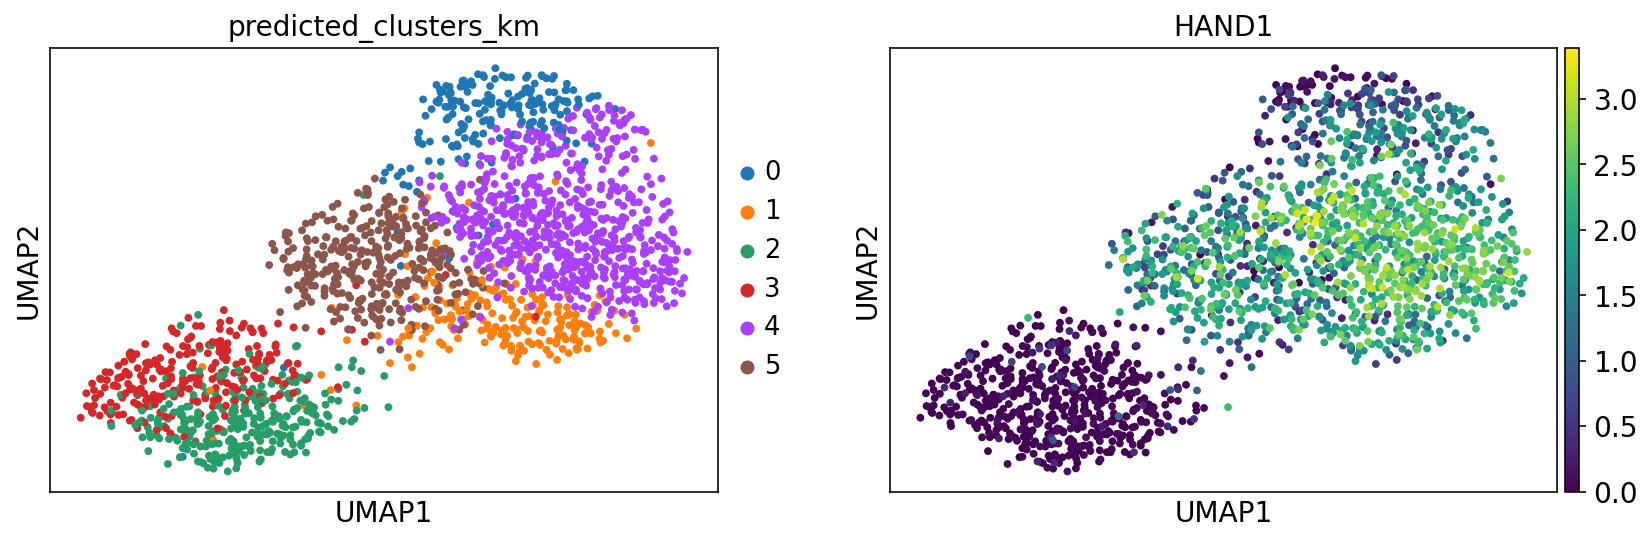

In [ ]:
from sklearn.metrics import silhouette_score,adjusted_rand_score
F1 = {}
for i in range(1,10):
  sil = silhouette_score(globals()["model"+str(i)+"_latent"],globals()["adata_"+str(i)].obs["predicted_clusters_km"])
  F1["model"+str(i)] = sil/(sil*(globals()["model"+str(i)+"_elbo"][-1]/10000)+1)
  print("model"+str(i)+": "+str(sil))

print(F1)

### Differential expression and finding marker genes

In [ ]:
# Function for ranking genes for each cluster
def rank_genes_groups_bayes(
    adata: sc.AnnData,
    scvi_posterior: scvi.inference.Posterior,
    n_samples: int = 5000,
    M_permutation: int = 10000,
    n_genes: int = 25,
    label_name: str = "predicted_clusters_km",
    mode: str = "vanilla"
) -> pd.DataFrame:
    """
    Rank genes for characterizing groups.
    Computes Bayes factor for each cluster against the others to test for differential expression.
    See Nature article (https://rdcu.be/bdHYQ)

    :param adata: sc.AnnData object non-normalized
    :param scvi_posterior:
    :param n_samples:
    :param M_permutation:
    :param n_genes:
    :param label_name: The groups tested are taken from adata.obs[label_name] which can be computed
                       using clustering like Louvain (Ex: sc.tl.louvain(adata, key_added=label_name) )
    :return: Summary of Bayes factor per gene, per cluster
    """

    # Call scvi function
    per_cluster_de, cluster_id = scvi_posterior.one_vs_all_degenes(
        cell_labels=np.asarray(adata.obs[label_name].values).astype(int).ravel(),
        min_cells=1,
        n_samples=n_samples,
        M_permutation=M_permutation,
        mode=mode
    )

    # convert to ScanPy format -- this is just about feeding scvi results into a format readable by ScanPy
    markers = []
    scores = []
    names = []
    for i, x in enumerate(per_cluster_de):
        subset_de = x[:n_genes]
        markers.append(subset_de)
        scores.append(tuple(subset_de["bayes_factor"].values))
        names.append(tuple(subset_de.index.values))

    markers = pd.concat(markers)
    dtypes_scores = [(str(i), "<f4") for i in range(len(scores))]
    dtypes_names = [(str(i), "<U50") for i in range(len(names))]
    scores = np.array([tuple(row) for row in np.array(scores).T], dtype=dtypes_scores)
    scores = scores.view(np.recarray)
    names = np.array([tuple(row) for row in np.array(names).T], dtype=dtypes_names)
    names = names.view(np.recarray)

    adata.uns["rank_genes_groups_scvi"] = {
        "params": {
            "groupby": "",
            "reference": "rest",
            "method": "",
            "use_raw": True,
            "corr_method": "",
        },
        "scores": scores,
        "names": names,
    }
    return markers

### ScanPy's Differential Expression Process - t-test and Wilcoxon test.

ranking genes
    finished (0:00:00)
ranking genes
    finished (0:00:00)


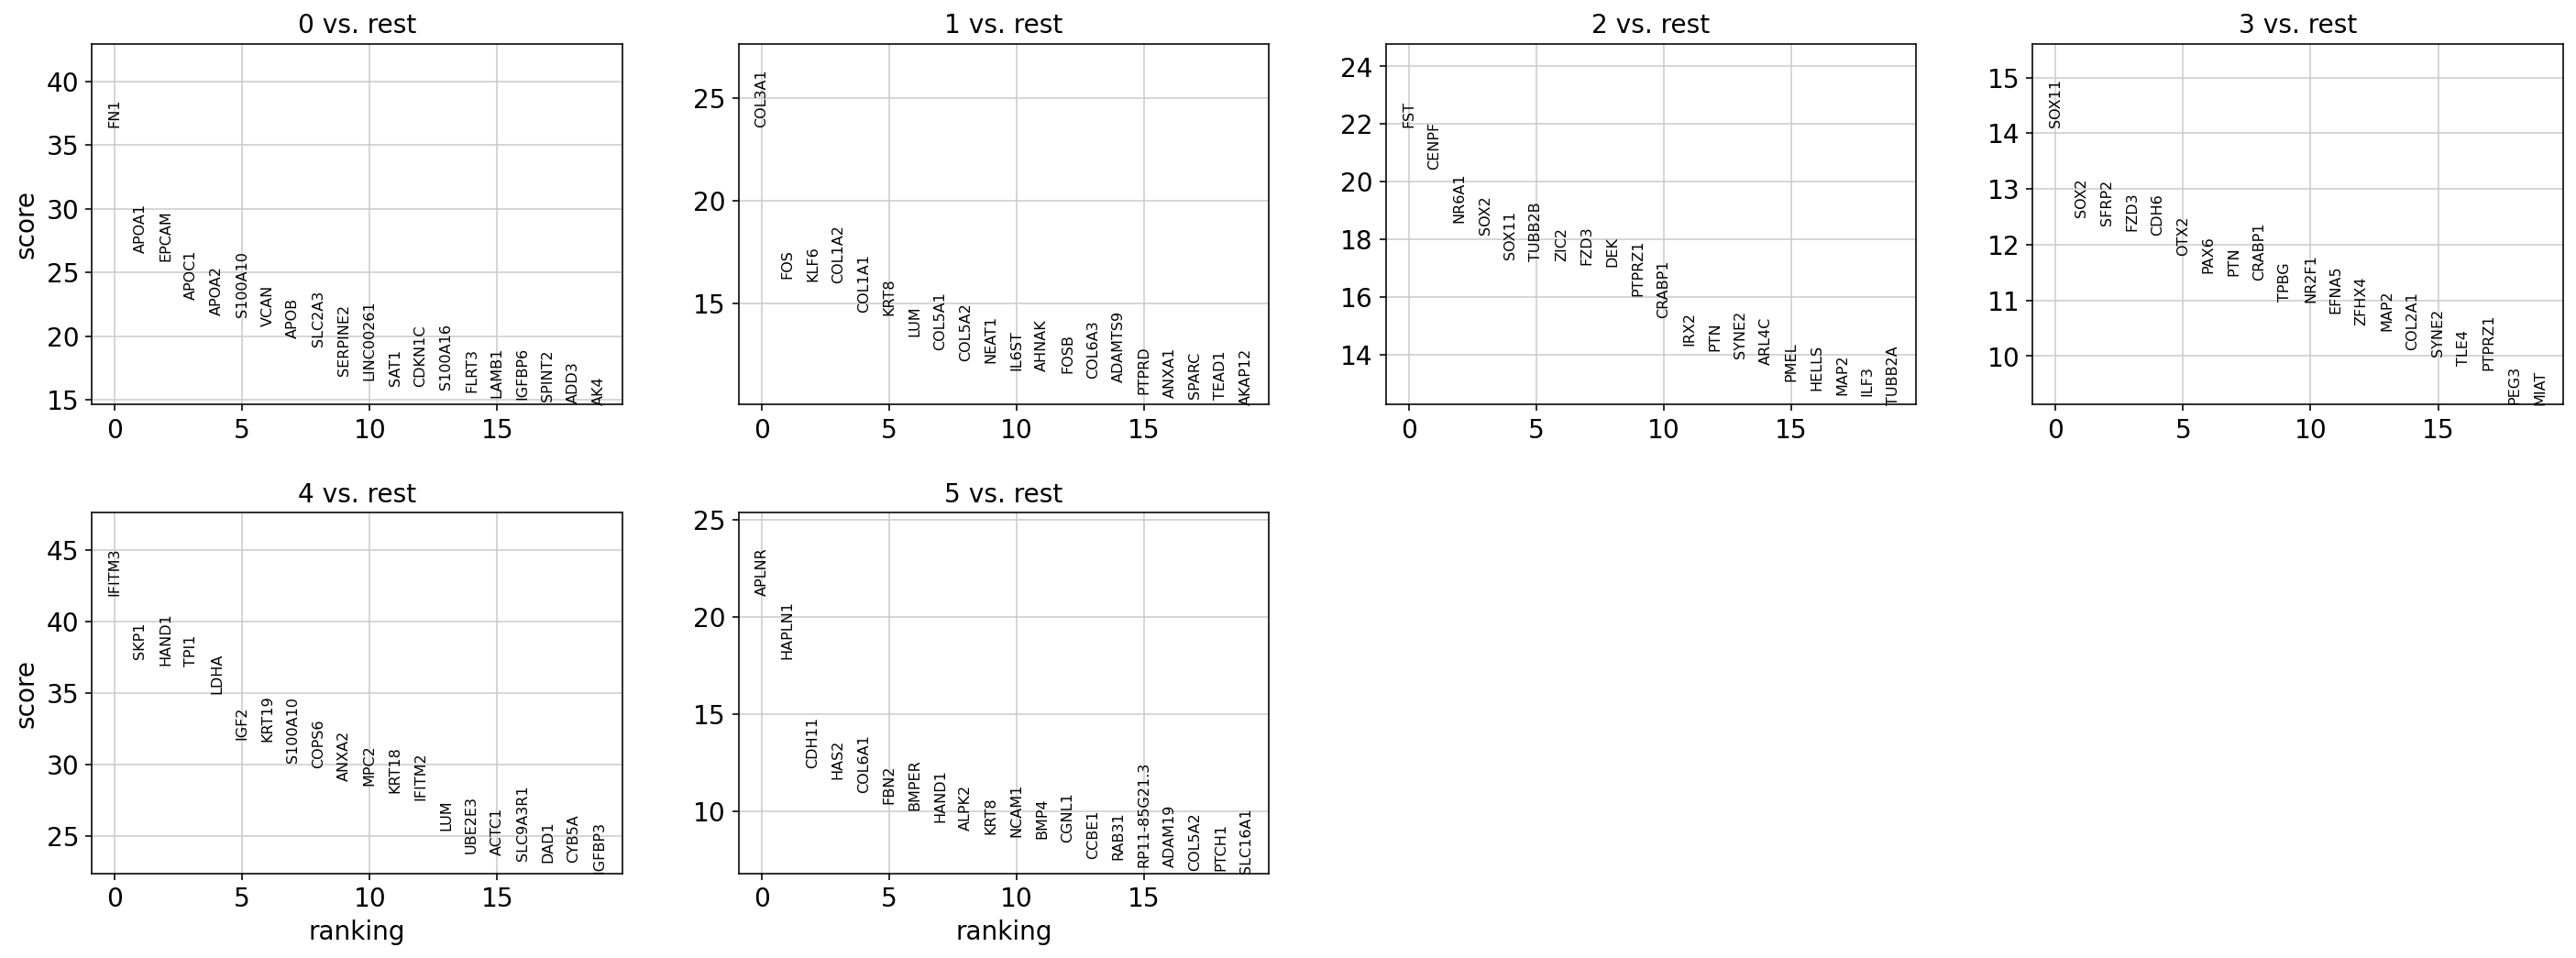

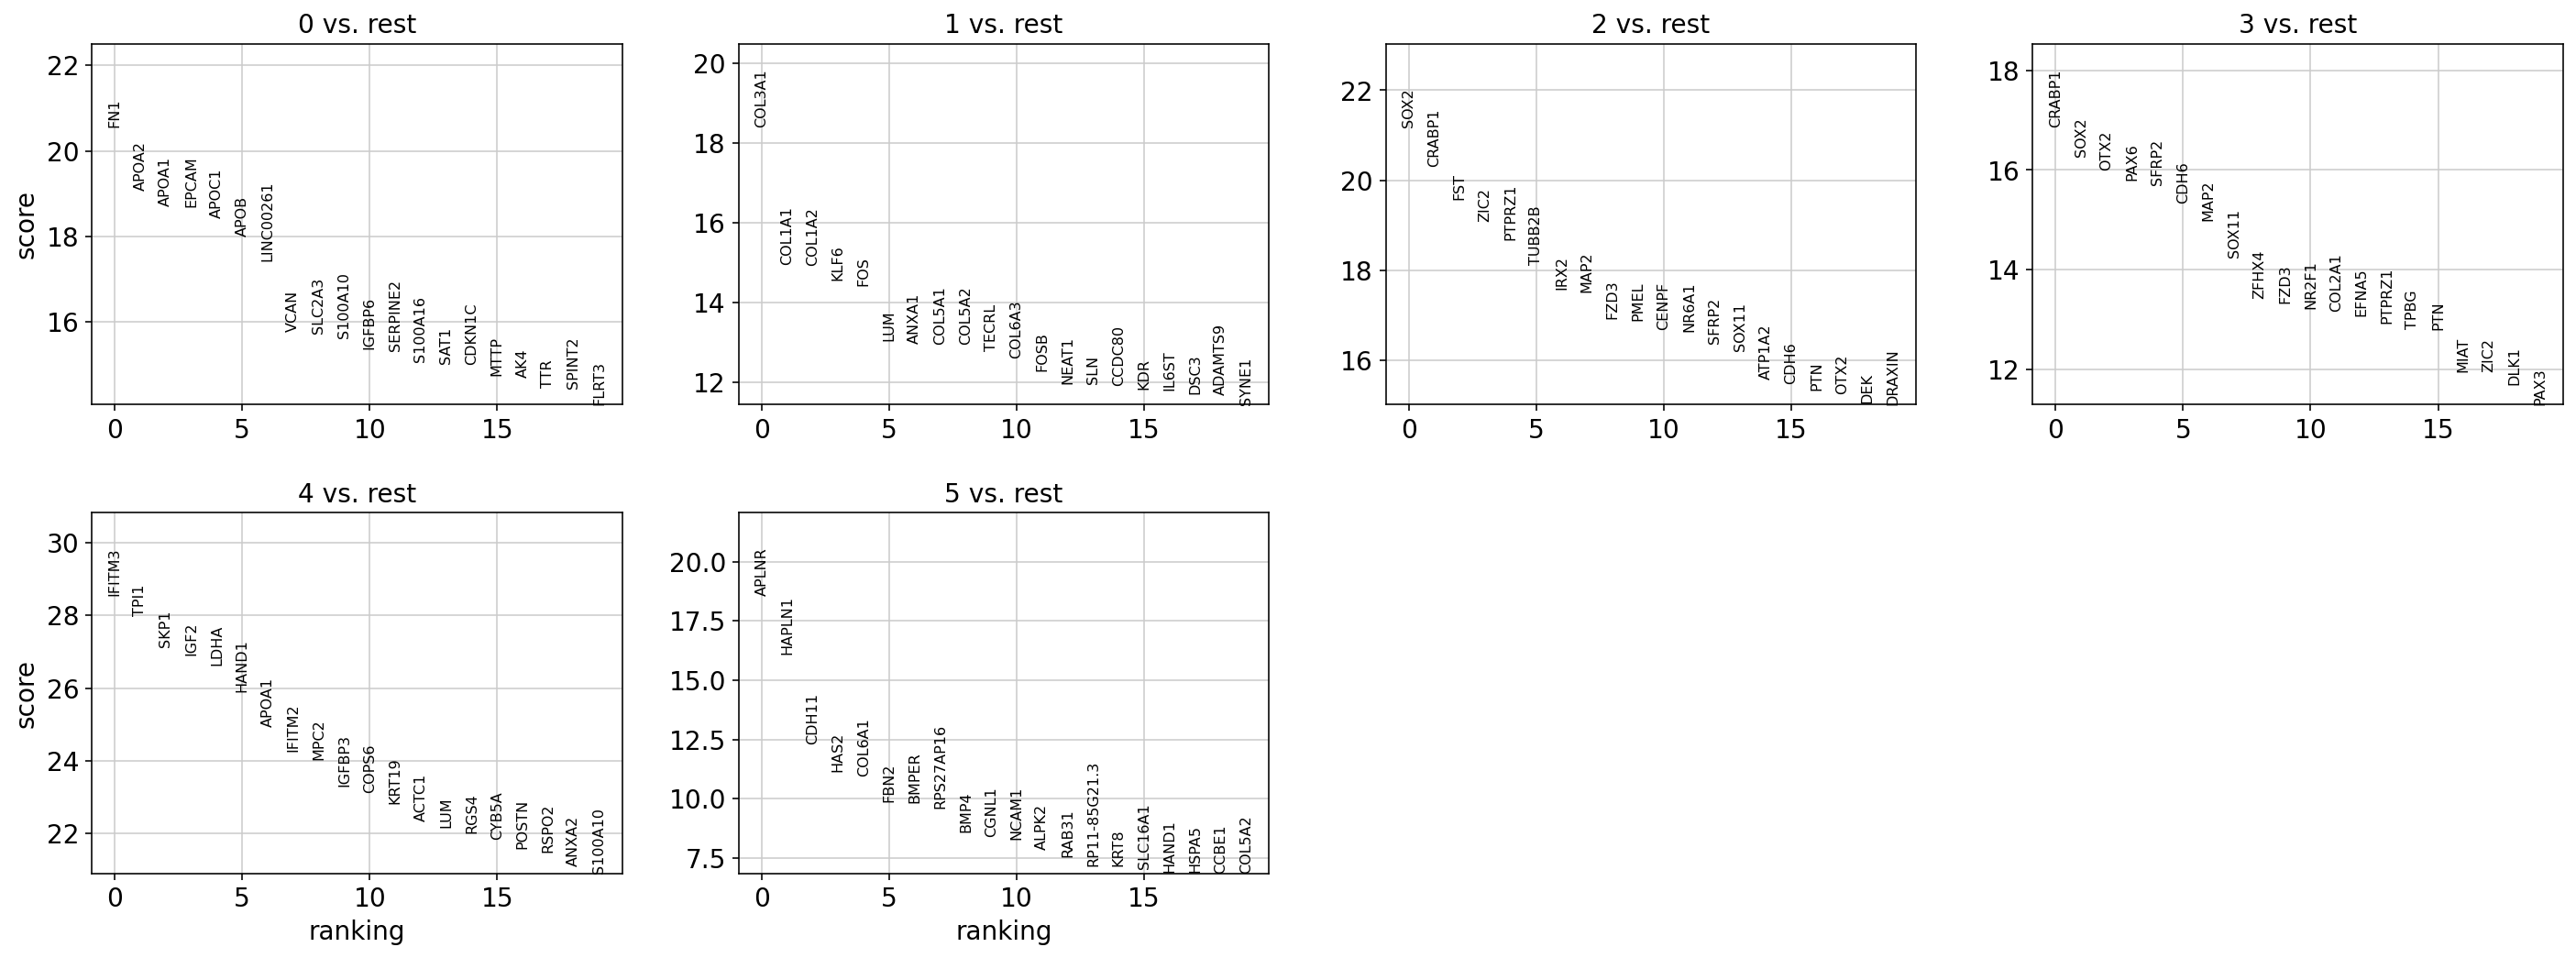

In [ ]:
n_genes = 20
sc.tl.rank_genes_groups(
    adata,
    "predicted_clusters_km",
    method="t-test",
    use_raw=True,
    key_added="rank_genes_groups_ttest",
    n_genes=n_genes,
)
sc.tl.rank_genes_groups(
    adata,
    "predicted_clusters_km",
    method="wilcoxon",
    use_raw=True,
    key_added="rank_genes_groups_wilcox",
    n_genes=n_genes,
)
sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_ttest", sharey=False, n_genes=n_genes, show=show_plot
)
sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_wilcox", sharey=False, n_genes=n_genes, show=show_plot
)

### scVI's Differential Expression process

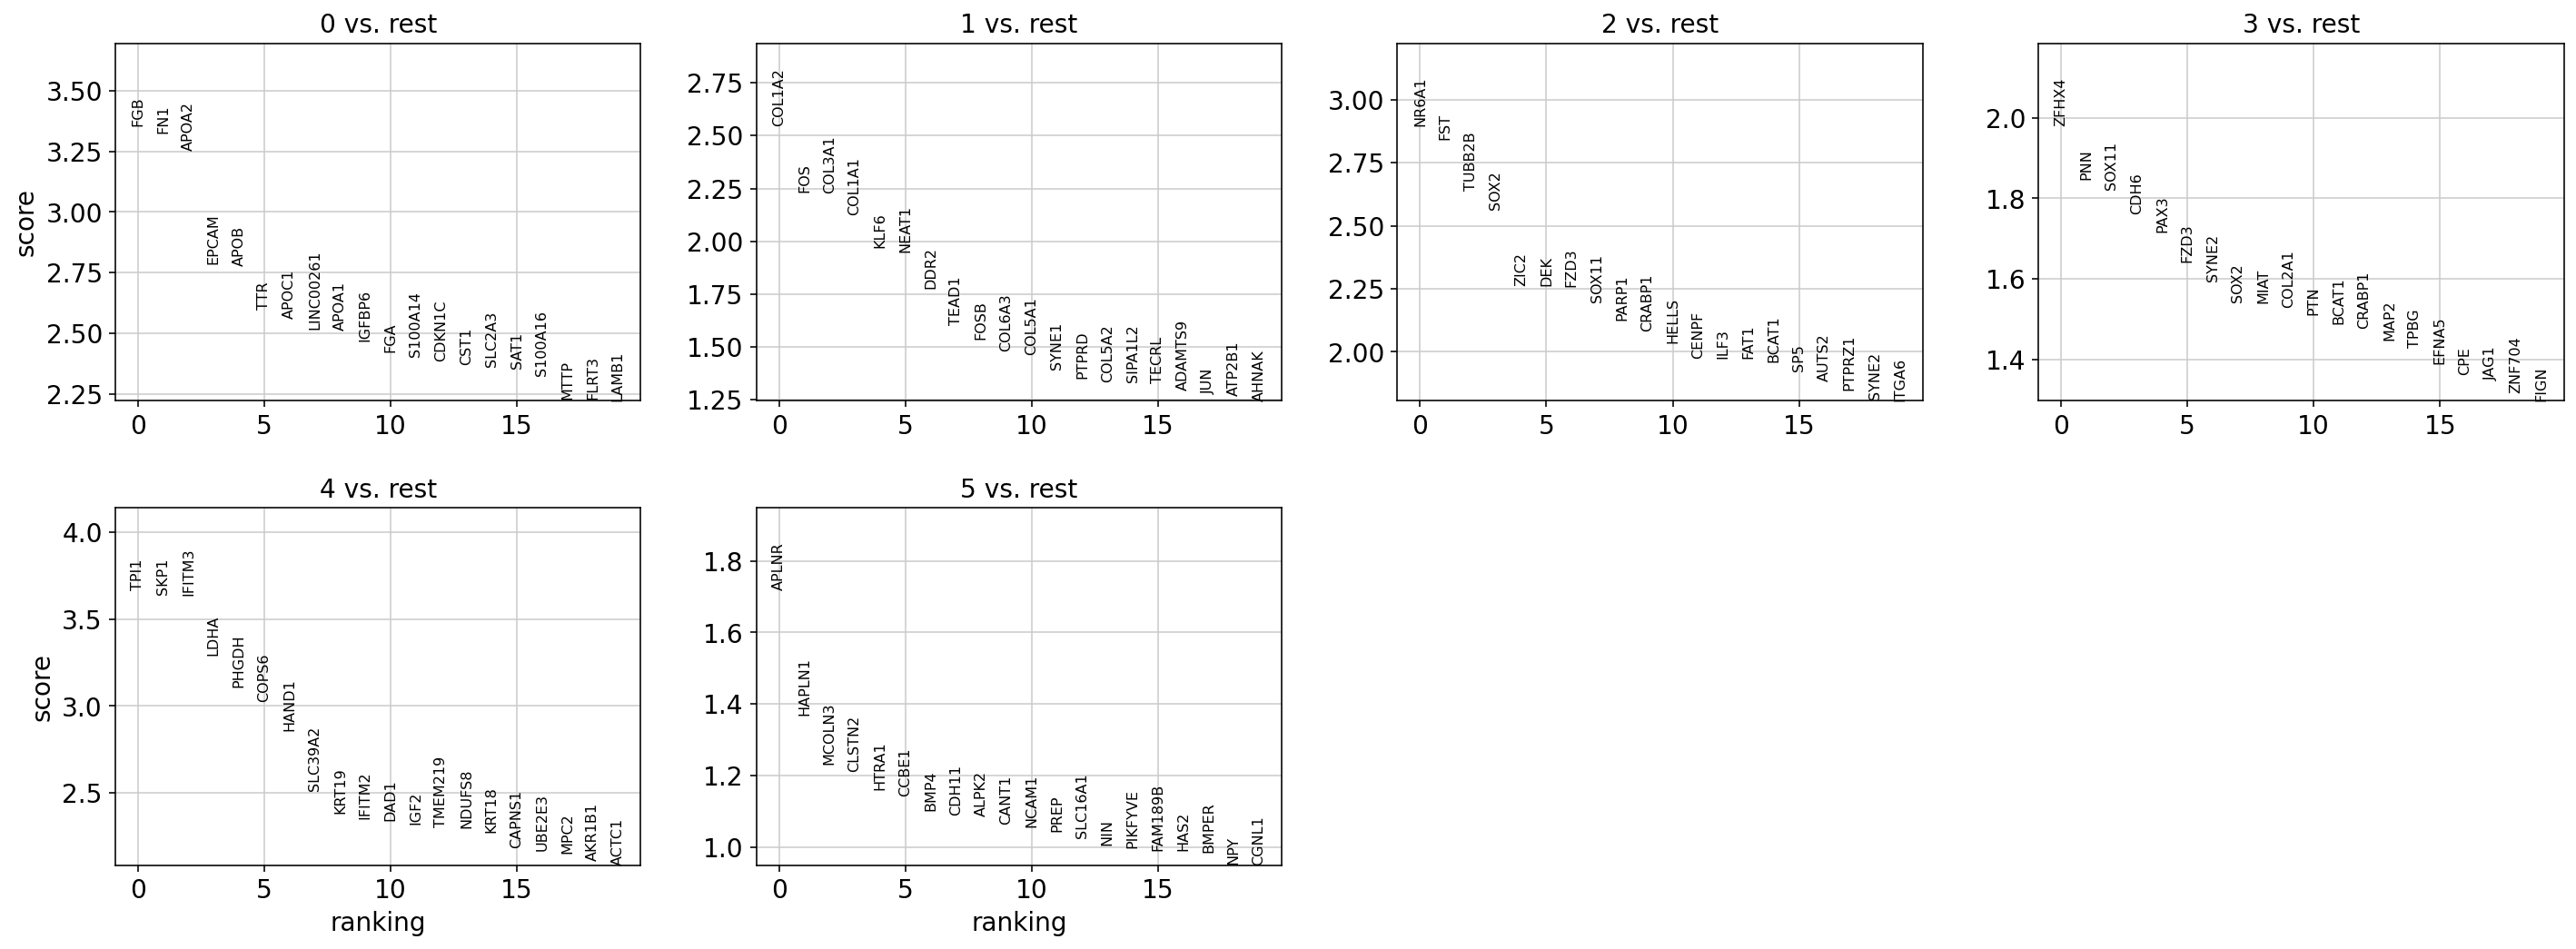

In [ ]:
rank_genes_groups_bayes(
    adata, scvi_posterior, label_name="predicted_clusters_km", n_genes=n_genes
)
sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_scvi", sharey=False, n_genes=n_genes, show=show_plot
)

In [ ]:
# We compute the rank of every gene to perform analysis after
all_genes = len(adata.var_names)
print(all_genes)
sc.tl.rank_genes_groups(adata, 'predicted_clusters_km', method='t-test',   use_raw=False, key_added='rank_genes_groups_ttest',  n_genes=all_genes)
sc.tl.rank_genes_groups(adata, 'predicted_clusters_km', method='wilcoxon', use_raw=False, key_added='rank_genes_groups_wilcox', n_genes=all_genes)
differential_expression = rank_genes_groups_bayes(adata, scvi_posterior, label_name='predicted_clusters_km', n_genes=all_genes)

1773
ranking genes
    finished (0:00:00)
ranking genes


/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished (0:00:00)


/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


In [ ]:
adata.uns["rank_genes_groups_ttest"]["names"][0]

('FN1', 'COL3A1', 'FST', 'SOX11', 'IFITM3', 'APLNR')

In [ ]:
differential_expression

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
FN1,0.9678,0.0322,3.403059,0.024290,0.003523,1621.180420,185.220581,1.000000,0.946561,79.056709,10.051056,0
FGB,0.9670,0.0330,3.377691,0.003463,0.000130,133.520615,4.028425,0.685567,0.254690,6.479294,0.240484,0
APOA2,0.9592,0.0408,3.157417,0.014118,0.000823,731.567017,27.568504,0.963918,0.587834,31.857641,1.643409,0
APOB,0.9436,0.0564,2.817233,0.007552,0.000415,331.257721,13.151222,0.917526,0.486640,15.171982,0.749925,0
EPCAM,0.9406,0.0594,2.762224,0.002408,0.000370,117.788658,15.596361,0.969072,0.518476,6.170816,1.013523,0
...,...,...,...,...,...,...,...,...,...,...,...,...
FRZB,0.1746,0.8254,-1.553370,0.000188,0.000680,2.929619,24.871588,0.225806,0.658809,0.280129,1.427648,5
DPYSL3,0.1516,0.8484,-1.722107,0.000333,0.000783,12.146627,36.581264,0.533724,0.858561,1.077373,2.241449,5
MAP2,0.1416,0.8584,-1.802064,0.000076,0.000938,0.398827,11.817617,0.058651,0.357320,0.032628,0.855159,5
VCAN,0.1372,0.8628,-1.838743,0.001259,0.003472,49.988270,158.724564,0.903226,0.990695,4.429408,9.129517,5


In [ ]:
def ratio(A, B):
    A, B = set(A), set(B)
    return len(A.intersection(B)) / len(A) * 100

In [ ]:
tuple(adata.uns["rank_genes_groups_ttest"]["names"][0])

('IFITM3', 'SOX2', 'FN1', 'APLNR', 'COL3A1', 'CENPF')

In [ ]:
cluster_distrib = adata.obs.groupby("predicted_clusters_km").count()["n_genes"]


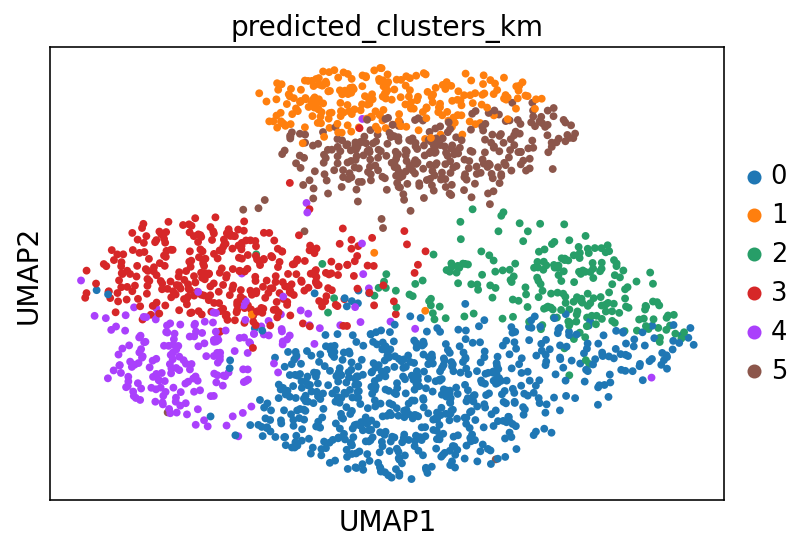

RecursionError: ignored

Cluster 0 (656 cells): t-test / wilcox  80.00 %  & t-test / scvi  20.00 %
Cluster 1 (234 cells): t-test / wilcox  40.00 %  & t-test / scvi   0.00 %
Cluster 2 (219 cells): t-test / wilcox  40.00 %  & t-test / scvi   0.00 %
Cluster 3 (339 cells): t-test / wilcox  40.00 %  & t-test / scvi   0.00 %
Cluster 4 (196 cells): t-test / wilcox  40.00 %  & t-test / scvi   0.00 %
Cluster 5 (309 cells): t-test / wilcox   0.00 %  & t-test / scvi   0.00 %


Exception ignored in: 'pandas._libs.lib.c_is_list_like'
Traceback (most recent call last):
  File "/usr/lib/python3.6/abc.py", line 184, in __instancecheck__
    if subclass in cls._abc_cache:
RecursionError: maximum recursion depth exceeded while calling a Python object


In [ ]:
n_genes = 5

sc.pl.umap(adata, color=["predicted_clusters_km"], ncols=1, show=show_plot)
for c in cluster_distrib.index:
    print(
        "Cluster %s (%d cells): t-test / wilcox %6.2f %%  & t-test / scvi %6.2f %%"
        % (
            c,
            cluster_distrib[c],
            ratio(
                tuple(adata.uns["rank_genes_groups_ttest"]["names"][c])[:n_genes],
                tuple(adata.uns["rank_genes_groups_wilcox"]["names"][c])[:n_genes],
            ),
            ratio(
                tuple(adata.uns["rank_genes_groups_ttest"]["names"][c])[:n_genes],
                tuple(adata.uns["rank_genes_groups_scvi"]["names"][c])[:n_genes],
            ),
        )
    )

### Differentially expressed genes in cluster 2 - high expression

In [ ]:
cluster_id = 4
n_best_genes = 10
gene_names = differential_expression[
    differential_expression["clusters"] == cluster_id
].index.tolist()[:n_best_genes]
gene_names

['IFITM3',
 'TPI1',
 'SKP1',
 'LDHA',
 'COPS6',
 'PHGDH',
 'HAND1',
 'IFITM2',
 'SLC39A2',
 'IGF2']

In [ ]:
print("Top genes for cluster %d" % cluster_id)
sc.pl.umap(adata, color=["predicted_clusters_km"] + ["scale_{}".format(g) for g in gene_names], ncols=3, show=show_plot)

### Differentially expressed genes in cluster 2 - low expression

In [ ]:
cluster_id = 2
n_best_genes = 10
gene_names = differential_expression[
    differential_expression["clusters"] == cluster_id
].index.tolist()[-n_best_genes:]
gene_names

['CTNND2',
 'MTTP',
 'HLA-DRB1',
 'SERPINF1',
 'SLC4A8',
 'CA4',
 'AK4',
 'RSPO3',
 'DPYSL3',
 'FRZB']

In [ ]:
print("Top down regulated genes for cluster %d" % cluster_id)
sc.pl.umap(adata, color=["predicted_clusters_km"] + ["scale_{}".format(g) for g in gene_names], ncols=3, show=show_plot)

In [ ]:
def store_de_scores(
    adata: sc.AnnData, differential_expression: pd.DataFrame, save_path: str = None
):
    """Creates, returns and writes a DataFrame with all the differential scores used in this notebook.

    Args:
        adata: scRNAseq dataset
        differential_expression: Pandas Dataframe containing the bayes factor for all genes and clusters
        save_path: file path for writing the resulting table

    Returns:
        pandas.DataFrame containing the scores of each differential expression test.

    """
    # get shapes for array initialisation
    n_genes_de = differential_expression[
        differential_expression["clusters"] == 0
    ].shape[0]
    all_genes = adata.shape[1]
    # check that all genes have been used
    if n_genes_de != all_genes:
        raise ValueError(
            "scvi differential expression has to have been run with n_genes=all_genes"
        )
    # get tests results from AnnData unstructured annotations
    rec_scores = []
    rec_names = []
    test_types = ["ttest", "wilcox"]
    for test_type in test_types:
        res = adata.uns["rank_genes_groups_" + test_type]
        rec_scores.append(res["scores"])
        rec_names.append(res["names"])
    # restrict scvi table to bayes factor
    res = differential_expression[["bayes_factor", "clusters"]]
    # for each cluster join then append all
    dfs_cluster = []
    groups = res.groupby("clusters")
    for cluster, df in groups:
        for rec_score, rec_name, test_type in zip(rec_scores, rec_names, test_types):
            temp = pd.DataFrame(
                rec_score[str(cluster)],
                index=rec_name[str(cluster)],
                columns=[test_type],
            )
            df = df.join(temp)
        dfs_cluster.append(df)
    res = pd.concat(dfs_cluster)
    if save_path:
        res.to_csv(save_path)
    return res

In [ ]:
de_table = store_de_scores(adata, differential_expression, save_path=None)
de_table.head()

,bayes_factor,clusters,ttest,wilcox
NBAS,2.052500,0,0.404606,-0.038745
CALR,2.011507,0,2.195621,4.157058
ERLIN2,1.902728,0,3.248391,3.070123
MCOLN3,1.878163,0,4.702312,3.330821
PITHD1,1.848918,0,-0.682363,0.167849


#### Partition-based graph abstraction (PAGA)

running PAGA
    finished (0:00:00)


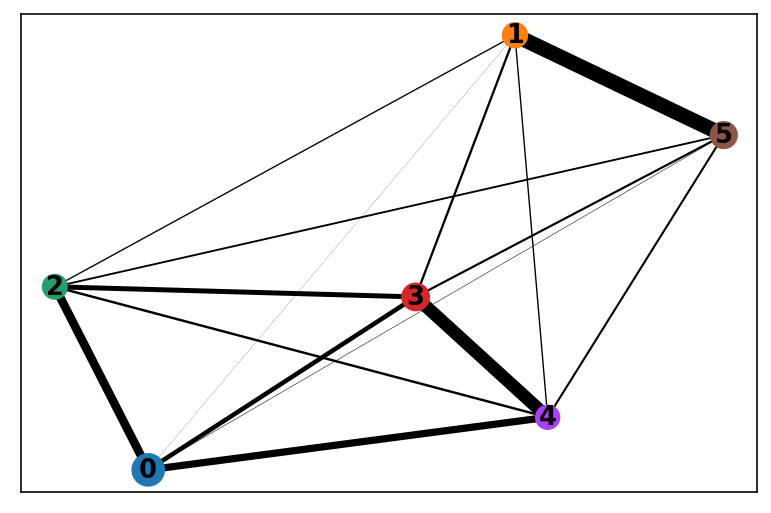

In [ ]:
sc.tl.paga(adata, groups="predicted_clusters_km")
sc.pl.paga(adata, show=show_plot)

In [ ]:
a1 = adata.obs["predicted_clusters_GMM"]
a2 = adata.obs["predicted_clusters_km"]

In [ ]:
a1.to_csv("/content/drive/My Drive/Systems Biology Project/Datasets and Analyses/EB/predicted_clusters_gmm.tsv",sep = "\t")
a2.to_csv("/content/drive/My Drive/Systems Biology Project/Datasets and Analyses/EB/predicted_clusters_km.tsv",sep = "\t")

In [ ]:
import pickle
with open("/content/drive/My Drive/Systems Biology Project/Codes/scVI series/models512_1_10.pickle", "rb") as f:
    adata_1,model1_posterior = pickle.load(f)

In [ ]:
all_genes = len(adata_1.var_names)
print(all_genes)
differential_expression = rank_genes_groups_bayes(adata_1, model1_posterior, label_name='predicted_clusters_km', n_genes=all_genes)
n_best_genes = 20
diff_genes = []
for i in range(6):
  gene_names = differential_expression[
      differential_expression["clusters"] == i
  ].index.tolist()[:n_best_genes]
  diff_genes.append(gene_names)
  print("cluster "+str(i),gene_names)

  0%|          | 0/6 [00:00<?, ?it/s]

1773


100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

cluster 0 ['KLF6', 'FOS', 'COL1A2', 'FOSB', 'COL3A1', 'NEAT1', 'COL5A2', 'COL5A1', 'SVEP1', 'JUN', 'COL1A1', 'HAPLN1', 'SEMA6D', 'SYNE1', 'SIPA1L2', 'ATP2B1', 'COBLL1', 'CDK6', 'CTGF', 'AHNAK']
cluster 1 ['IFITM3', 'LDHA', 'SKP1', 'HAND1', 'TPI1', 'COPS6', 'PHGDH', 'UBE2E3', 'IFITM2', 'SLC39A2', 'DAD1', 'NDUFS8', 'IGF2', 'VPS28', 'RP11-834C11.4', 'RGS4', 'ACTC1', 'LUM', 'AKR1B1', 'MPC2']
cluster 2 ['MCOLN3', 'APLNR', 'CEP104', 'HEATR1', 'ERLIN2', 'FAM20B', 'KMT5B', 'DRD2', 'CTDSPL', 'SASS6', 'C2orf49', 'HAPLN1', 'SFXN2', 'CDH11', 'ROR2', 'MXRA5', 'LRRC32', 'SLC39A6', 'GPAM', 'RNF13']
cluster 3 ['TMEM80', 'MAP2', 'CRABP1', 'SOX11', 'PTN', 'MIAT', 'ZNF138', 'FZD3', 'FST', 'SYNE2', 'SOX2', 'ILDR2', 'MAP3K4', 'CDH6', 'PNN', 'GPM6B', 'PTPRZ1', 'IGFBP5', 'ZIC2', 'TFAP2A']
cluster 4 ['FST', 'SOX11', 'TUBB2B', 'SOX2', 'BCAT1', 'CENPF', 'FZD3', 'NR6A1', 'PTPRZ1', 'SYNE2', 'DNMT1', 'ARL4C', 'GREB1L', 'PNN', 'MIAT', 'BPTF', 'PHIP', 'ZIC2', 'ZNF462', 'DEK']
cluster 5 ['APOA2', 'APOC1', 'APOB', 'TT

In [ ]:
import scanpy as sc
cluster_id = 5
n_best_genes = 1
gene_names = differential_expression[
    differential_expression["clusters"] == cluster_id
].index.tolist()[:n_best_genes]

print("Top genes for cluster %d" % cluster_id)
sc.pl.umap(adata_1, color=["predicted_clusters_km"] + ["scale_{}".format(g) for g in gene_names], ncols=3, show=show_plot)


NameError: ignored

In [ ]:
differential_expression[differential_expression["clusters"]==5]

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
APOA2,0.9924,0.0076,4.871977,0.009990,0.000245,648.825928,9.051693,0.985185,0.567439,29.208090,0.704072,5
APOC1,0.9844,0.0156,4.144761,0.007044,0.000384,208.114822,10.213309,0.985185,0.670826,11.363133,0.802397,5
APOB,0.9822,0.0178,4.010596,0.003713,0.000126,291.570374,5.153298,0.948148,0.462270,13.460249,0.373271,5
TTR,0.9814,0.0186,3.965818,0.007831,0.000184,534.311096,6.691622,0.900000,0.489008,24.757023,0.546636,5
IGFBP6,0.9806,0.0194,3.922891,0.001489,0.000079,70.851852,2.957219,0.896296,0.272727,3.926302,0.211206,5
...,...,...,...,...,...,...,...,...,...,...,...,...
UNC5C,0.1344,0.8656,-1.862602,0.000041,0.000273,1.703704,5.068924,0.229630,0.307190,0.109250,0.359385,5
ZEB2,0.1190,0.8810,-2.001934,0.000217,0.000709,4.792593,21.232918,0.477778,0.681521,0.289722,1.392345,5
GLI3,0.1118,0.8882,-2.072485,0.000131,0.000523,3.159259,16.323826,0.385185,0.641117,0.178365,1.112889,5
PTN,0.1004,0.8996,-2.192788,0.000329,0.001803,4.903704,38.076054,0.414815,0.693405,0.305335,2.678840,5


In [ ]:
all_genes = len(adata_1.var_names)
print(all_genes)
differential_expression = rank_genes_groups_bayes(adata_1, model1_posterior, label_name='predicted_clusters_km', n_genes=all_genes)
n_best_genes = 20
diff_genes = []
for i in range(6):
  gene_names = differential_expression[
      differential_expression["clusters"] == i
  ].index.tolist()[:n_best_genes]
  diff_genes.append(gene_names)
  print("cluster "+str(i),gene_names)

  0%|          | 0/6 [00:00<?, ?it/s]

1773


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

cluster 0 ['KLF6', 'FOS', 'COL1A2', 'FOSB', 'COL3A1', 'NEAT1', 'COL5A1', 'COL5A2', 'SVEP1', 'HAPLN1', 'COL1A1', 'SEMA6D', 'JUN', 'COBLL1', 'SIPA1L2', 'ALPK2', 'KDR', 'ATP2B1', 'SYNE1', 'PTPRD']
cluster 1 ['IFITM3', 'LDHA', 'SKP1', 'TPI1', 'HAND1', 'COPS6', 'PHGDH', 'IFITM2', 'UBE2E3', 'SLC39A2', 'IGF2', 'DAD1', 'VPS28', 'NDUFS8', 'RP11-834C11.4', 'RGS4', 'MPC2', 'ACTC1', 'LUM', 'DCTN2']
cluster 2 ['MCOLN3', 'CEP104', 'APLNR', 'KMT5B', 'FAM20B', 'ERLIN2', 'HEATR1', 'DRD2', 'CTDSPL', 'SASS6', 'HAPLN1', 'C2orf49', 'SFXN2', 'RNF13', 'MXRA5', 'GPAM', 'CDH11', 'PYGO1', 'RFX3', 'SNX19']
cluster 3 ['TMEM80', 'CRABP1', 'MAP2', 'MIAT', 'SOX11', 'PTN', 'FZD3', 'ZNF138', 'FST', 'SYNE2', 'CDH6', 'ILDR2', 'MAP3K4', 'SOX2', 'GPM6B', 'PTPRZ1', 'TFAP2A', 'PNN', 'IGFBP5', 'ZIC2']
cluster 4 ['FST', 'TUBB2B', 'SOX11', 'SOX2', 'BCAT1', 'PTPRZ1', 'CENPF', 'NR6A1', 'DNMT1', 'SYNE2', 'FZD3', 'ARL4C', 'ZIC2', 'GREB1L', 'BPTF', 'MIAT', 'PHIP', 'DEK', 'ASPM', 'ILF3']
cluster 5 ['APOA2', 'APOC1', 'APOB', 'IGFBP6'

In [ ]:
n_genes = 20
sc.tl.rank_genes_groups(
    adata_1,
    "predicted_clusters_km",
    method="t-test",
    use_raw=True,
    key_added="rank_genes_groups_ttest",
    n_genes=n_genes,
)
sc.tl.rank_genes_groups(
    adata_1,
    "predicted_clusters_km",
    method="wilcoxon",
    use_raw=True,
    key_added="rank_genes_groups_wilcox",
    n_genes=n_genes,
)
sc.pl.rank_genes_groups(
    adata_1, key="rank_genes_groups_ttest", sharey=False, n_genes=n_genes, show=show_plot
)
sc.pl.rank_genes_groups(
    adata_1, key="rank_genes_groups_wilcox", sharey=False, n_genes=n_genes, show=show_plot
)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
rank_genes_groups_bayes(
    adata_1, model1_posterior, label_name="predicted_clusters_km", n_genes=20
)
sc.pl.rank_genes_groups(
    adata_1, key="rank_genes_groups_scvi", sharey=False, n_genes=20, show=True
)

100%|██████████| 6/6 [00:03<00:00,  1.58it/s]


In [ ]:
len(model1_posterior.get_stats())

1953

In [ ]:
adata_1

AnnData object with n_obs × n_vars = 1953 × 1773
    obs: 'n_genes', 'percent_mito', 'n_counts', 'scale_ISG15', 'scale_TPRG1L', 'scale_LRRC47', 'scale_CEP104', 'scale_ACOT7', 'scale_NOL9', 'scale_KIF1B', 'scale_PGD', 'scale_DRAXIN', 'scale_VPS13D', 'scale_PDPN', 'scale_DNAJC16', 'scale_DDI2', 'scale_PLEKHM2', 'scale_FBXO42', 'scale_UBR4', 'scale_EMC1', 'scale_AKR7A2', 'scale_MUL1', 'scale_PITHD1', 'scale_HMGCL', 'scale_SRSF10', 'scale_TMEM57', 'scale_GMEB1', 'scale_EPB41', 'scale_MECR', 'scale_PEF1', 'scale_TXLNA', 'scale_ZBTB8A', 'scale_ZMYM4', 'scale_AGO1', 'scale_TRAPPC3', 'scale_LSM10', 'scale_MYCBP', 'scale_AKIRIN1', 'scale_PPIH', 'scale_SLC2A1', 'scale_CDC20', 'scale_DMAP1', 'scale_KIF2C', 'scale_EIF2B3', 'scale_HECTD3', 'scale_PIK3R3', 'scale_POMGNT1', 'scale_STIL', 'scale_RAB3B', 'scale_ZFYVE9', 'scale_ZCCHC11', 'scale_LRRC42', 'scale_JUN', 'scale_L1TD1', 'scale_DOCK7', 'scale_ALG6', 'scale_ROR1', 'scale_CACHD1', 'scale_JAK1', 'scale_AK4', 'scale_TYW3', 'scale_USP33', 'scale_PR

In [ ]:
sc.pl.umap(adata_1, color=["predicted_clusters_gmm"], ncols=1, show=show_plot)